In [1]:
import mcnpy
from mcnpy.ace.analysis import get_cross_section_dataframe
import os
from mcnpy.utils import configure_ace_debug_logging

# Configure debug logging
configure_ace_debug_logging(enable=True)  # Set to False to disable debug output

<RootLogger root (DEBUG)>

In [2]:
acefile = 'files/260560_80.06c'

In [3]:
ace = mcnpy.read_ace(acefile)

DEBUG - mcnpy.ace.parsers.parse_energy_distributions - WARNING: Unexpected LAW value: 33. Valid laws are: [1, 2, 3, 4, 5, 7, 9, 11, 22, 24, 44, 61, 66, 67]
DEBUG - mcnpy.ace.parsers.parse_energy_distributions - WARNING: Unexpected LAW value: 33. Valid laws are: [1, 2, 3, 4, 5, 7, 9, 11, 22, 24, 44, 61, 66, 67]
DEBUG - mcnpy.ace.parsers.parse_energy_distributions - WARNING: Unexpected LAW value: 33. Valid laws are: [1, 2, 3, 4, 5, 7, 9, 11, 22, 24, 44, 61, 66, 67]
DEBUG - mcnpy.ace.parsers.parse_energy_distributions - WARNING: Unexpected LAW value: 33. Valid laws are: [1, 2, 3, 4, 5, 7, 9, 11, 22, 24, 44, 61, 66, 67]
DEBUG - mcnpy.ace.parsers.parse_energy_distributions - WARNING: Unexpected LAW value: 33. Valid laws are: [1, 2, 3, 4, 5, 7, 9, 11, 22, 24, 44, 61, 66, 67]
DEBUG - mcnpy.ace.parsers.parse_energy_distributions - WARNING: Unexpected LAW value: 33. Valid laws are: [1, 2, 3, 4, 5, 7, 9, 11, 22, 24, 44, 61, 66, 67]
DEBUG - mcnpy.ace.parsers.parse_energy_distributions - WARNING: 

In [12]:
ace.energy_distributions.incident_neutron[5][0]

                  Tabulated Angle-Energy Distribution (Law 61)                  
This distribution provides correlated angle-energy distributions using tabular
angular distributions. It corresponds to Law 61 in the ACE format.
Similar to LAW=44 but uses tabular angular distributions instead of Kalbach-Mann formalism.

Basic Properties:
--------------------------------------------------------------------------------
Distribution Law                         61 (Tabulated Angle-Energy)          
Number of Interpolation Regions          0                                    
Number of Incident Energies              46                                   
Incident Energy Range                    1.0000e-11 - 1.5000e+02 MeV          
Number of Energy Distributions           46                                   
Number of Angular Tables                 2403                                 
--------------------------------------------------------------------------------

Available Methods:
------

In [13]:
ace.unresolved_resonance

No unresolved resonance probability tables available

In [2]:
acefile1 = 'files/922350_71.02c'

In [3]:
ace1 = mcnpy.read_ace(acefile1)

In [4]:
ace1.unresolved_resonance

                       Unresolved Resonance Probability Tables                       

Unresolved resonance probability tables contain cross section data for the unresolved
resonance energy range. These tables allow for stochastic treatment of self-shielding
effects in the unresolved resonance range during transport calculations.

Summary Information:
-------------------------------------------------------------------------------------
Property                            Value                                          
-------------------------------------------------------------------------------------
Number of energy points             14                                             
Table length                        20                                             
Interpolation method                linear-linear                                  
Inelastic cross section             Special MT=4                                   
Other absorption cross section      Zero in the unreso

In [ ]:
#JXS(32)
3302476 + 10 *(1-1) + 8

3302484

In [ ]:
# JED de DLWH
3317561 + 96 - 1

3317656

In [ ]:
ace.energy_distributions.get_neutron_distribution(5)[0].distributions


[]

In [ ]:
dist = ang.incident_neutron[16]
dist

                      Kalbach-Mann Angular Distribution Details                      

This object represents an angular distribution using the Kalbach-Mann formalism.
The Kalbach-Mann model correlates energy and angle distributions, with parameters
R (precompound fraction) and A (angular slope) that vary with outgoing energy.

Data Structure Overview:
- In the ACE file, a LOCB value of -1 indicates a Kalbach-Mann distribution
- The actual angular distribution parameters (R and A) are stored in the
  energy distribution section as a Law=44 distribution
- This object stores reference indices to locate the Law=44 data when needed

IMPORTANT: This distribution REQUIRES Law=44 data from the energy distribution
section (DLW/DLWH blocks). The ACE object must be provided to all methods that
calculate or sample angular distributions. Without this data, methods will raise
a Law44DataError exception.

Data Information:
-----------------------------------------------------------------------------

In [ ]:
ace.energy_distributions

                            Energy Distribution Container                            

This container holds energy distributions for secondary particles produced in nuclear reactions.
Distributions are organized by particle type (neutron, photon, other) and reaction (MT number).
Each reaction can have multiple distribution laws that apply in different energy ranges.

Available Energy Distribution Data:
-------------------------------------------------------------------------------------
Distribution Type                        Status                                    
-------------------------------------------------------------------------------------
Incident Neutron Distributions           Available (42 MT numbers)                 
Photon Production Distributions          Available (532 MT numbers)                
Particle Production Distributions        Available (5 particle types)              
Delayed Neutron Distributions            None (0 groups)                           
En

In [ ]:
ace.energy_distributions.print_distribution_info()

                                Energy Distribution Type Information                                

Incident Neutron Energy Distributions
----------------------------------------------------------------------------------------------------
MT       Law      Distribution Type              Access Method                                     
----------------------------------------------------------------------------------------------------
5        61       TabulatedAngleEnergyDistribution .get_neutron_distribution(5)                      
16       61       TabulatedAngleEnergyDistribution .get_neutron_distribution(16)                     
51       3        LevelScattering                .get_neutron_distribution(51)                     
52       3        LevelScattering                .get_neutron_distribution(52)                     
53       3        LevelScattering                .get_neutron_distribution(53)                     
54       3        LevelScattering                .get_

In [ ]:
ace.energy_distributions.get_neutron_distribution(5)[0]

                  Tabulated Angle-Energy Distribution (Law 61)                  
This distribution provides correlated angle-energy distributions using tabular
angular distributions. It corresponds to Law 61 in the ACE format.
Similar to LAW=44 but uses tabular angular distributions instead of Kalbach-Mann formalism.

Basic Properties:
--------------------------------------------------------------------------------
Distribution Law                         61 (Tabulated Angle-Energy)          
Number of Interpolation Regions          2                                    
Number of Incident Energies              0                                    
Number of Energy Distributions           0                                    
Number of Angular Tables                 0                                    
--------------------------------------------------------------------------------

Available Methods:
--------------------------------------------------------------------------------
Meth

In [ ]:
ace.energy_distributions.get_neutron_distribution(5)[0].applicability_energies

[XssEntry(Index=2067964, Value=1e-11),
 XssEntry(Index=2067965, Value=6.0),
 XssEntry(Index=2067966, Value=10.5),
 XssEntry(Index=2067967, Value=11.0),
 XssEntry(Index=2067968, Value=11.25),
 XssEntry(Index=2067969, Value=11.5),
 XssEntry(Index=2067970, Value=12.0),
 XssEntry(Index=2067971, Value=12.5),
 XssEntry(Index=2067972, Value=13.0),
 XssEntry(Index=2067973, Value=13.5),
 XssEntry(Index=2067974, Value=14.0),
 XssEntry(Index=2067975, Value=14.5),
 XssEntry(Index=2067976, Value=15.0),
 XssEntry(Index=2067977, Value=16.0),
 XssEntry(Index=2067978, Value=16.5),
 XssEntry(Index=2067979, Value=18.0),
 XssEntry(Index=2067980, Value=19.0),
 XssEntry(Index=2067981, Value=20.0),
 XssEntry(Index=2067982, Value=22.0),
 XssEntry(Index=2067983, Value=24.0),
 XssEntry(Index=2067984, Value=25.7),
 XssEntry(Index=2067985, Value=28.0),
 XssEntry(Index=2067986, Value=30.0),
 XssEntry(Index=2067987, Value=32.0),
 XssEntry(Index=2067988, Value=34.0),
 XssEntry(Index=2067989, Value=36.0),
 XssEntry(I

In [ ]:
ang.incident_neutron[51].to_dataframe(energy=14)

,cosine,probability
0,-1.000000,0.099977
1,-0.979798,0.219170
2,-0.959596,0.294011
3,-0.939394,0.335204
4,-0.919192,0.350943
...,...,...
95,0.919192,1.159403
96,0.939394,0.984290
97,0.959596,0.777105
98,0.979798,0.550318


In [ ]:
acefile_og = 'files/260560_80.06c_0002'
acefile_pert = 'files/260560_80.06c_0001'

In [ ]:
ace_og = mcnpy.read_ace(acefile_og)
ace_pert = mcnpy.read_ace(acefile_pert)

KeyboardInterrupt: 

In [ ]:
df = get_cross_section_dataframe([ace_og, ace_pert], 51)
df

,Energy,26056,26056_1
0,1.000000e-11,0.000000,0.000000
1,1.031250e-11,0.000000,0.000000
2,1.062500e-11,0.000000,0.000000
3,1.093750e-11,0.000000,0.000000
4,1.125000e-11,0.000000,0.000000
...,...,...,...
41041,1.250000e+02,0.005195,0.005195
41042,1.300000e+02,0.004796,0.004796
41043,1.400000e+02,0.004115,0.004115
41044,1.499999e+02,0.003563,0.003563


Are the columns exactly the same? False
Maximum absolute difference: 0.24363707434000004


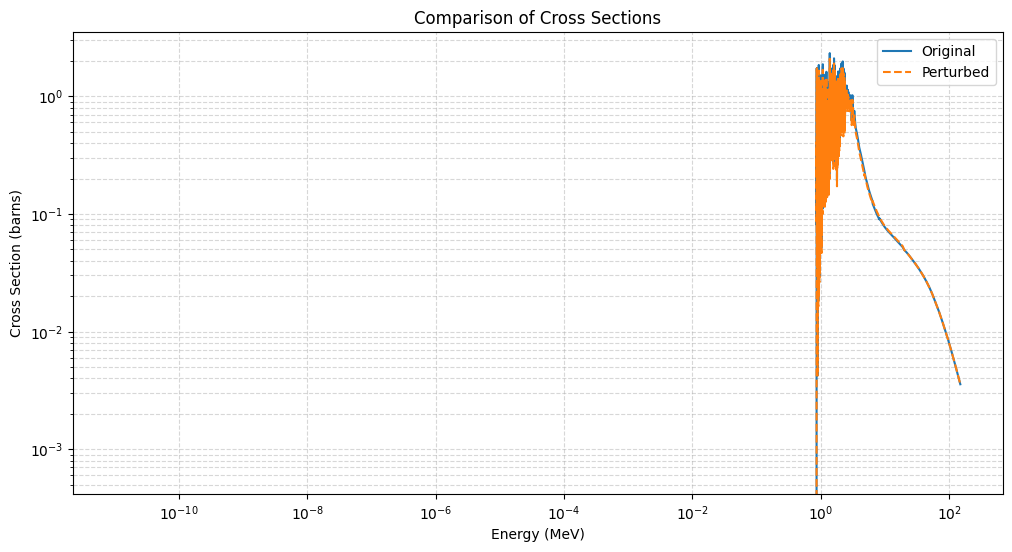

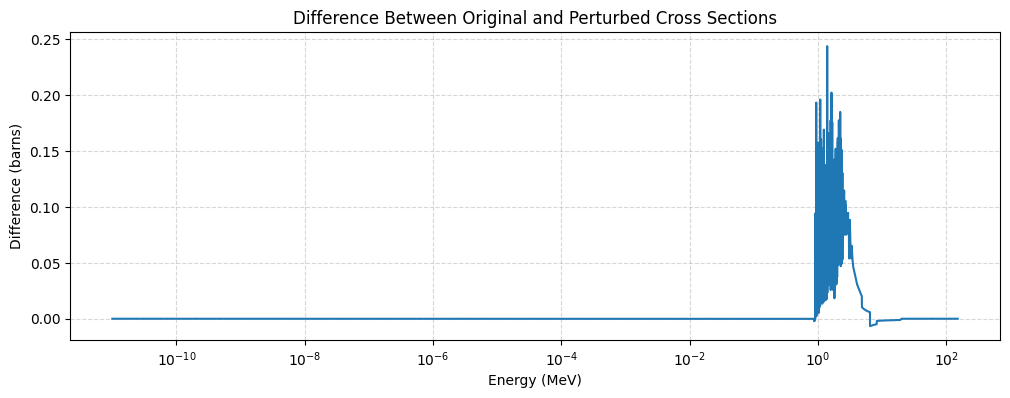

In [ ]:
import numpy as np

import matplotlib.pyplot as plt

# Check if both columns are exactly the same
exact_match = (df[26056] == df['26056_1']).all()
print(f"Are the columns exactly the same? {exact_match}")

# Calculate the absolute difference between columns
diff = df[26056] - df['26056_1']
max_diff = np.abs(diff).max()
print(f"Maximum absolute difference: {max_diff}")

# Plot both cross sections
plt.figure(figsize=(12, 6))
plt.plot(df['Energy'], df[26056], label='Original')
plt.plot(df['Energy'], df['26056_1'], label='Perturbed', linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Energy (MeV)')
plt.ylabel('Cross Section (barns)')
plt.title('Comparison of Cross Sections')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)

# Plot the difference
if not exact_match:
    plt.figure(figsize=(12, 4))
    plt.plot(df['Energy'], diff)
    plt.xscale('log')
    plt.xlabel('Energy (MeV)')
    plt.ylabel('Difference (barns)')
    plt.title('Difference Between Original and Perturbed Cross Sections')
    plt.grid(True, which='both', linestyle='--', alpha=0.5)

In [ ]:
.

SyntaxError: invalid syntax (1933637684.py, line 1)

In [ ]:
# Define all ACE files to test
acefile = 'files/10010_71.02c'
acefile_U235 = 'files/922350_71.02c'
acefile1 = 'files/FE56.293600c'
acefile2 = 'files/260560_80.02c'

# Print files to verify they exist
for file_path in [acefile, acefile_U235, acefile1, acefile2]:
    print(f"File {file_path} exists: {os.path.exists(file_path)}")

File files/10010_71.02c exists: True
File files/922350_71.02c exists: True
File files/FE56.293600c exists: True
File files/260560_80.02c exists: True


In [ ]:
ace_U235 = mcnpy.read_ace(acefile_U235)

In [ ]:
ace_U235.unresolved_resonance

Unresolved Resonance Probability Tables
Number of energy points: 14
Table length: 20
Interpolation: linear-linear
Inelastic cross section: special MT=4
Other absorption cross section: zero in the unresolved range
Table values represent factors to multiply smooth cross sections
Energy range: 2.250001e-03 to 2.499999e-02 MeV
Total cross section range: 6.280051e-01 to 1.891055e+00 (factors)

In [ ]:
print(ace_U235.mt_numbers)

[1, 2, 4, 16, 17, 18, 37, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 101, 102, 444]


In [ ]:
ace_U235.cross_section.reaction.keys()

dict_keys([1, 2, 101, 16, 17, 18, 37, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 102, 444, 4])

In [ ]:
print(ace_U235.cross_section.mt_numbers)

[1, 2, 4, 16, 17, 18, 37, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 101, 102, 444]


In [ ]:
ace_U235.cross_section.reaction[4].to_dataframe()

,Energy,Cross Section
0,0.00225,0.000000e+00
1,0.00225,1.204971e-07
2,0.00230,1.251350e-07
3,0.00240,1.342625e-07
4,0.00250,1.433900e-07
...,...,...
425,18.00000,4.111469e-01
426,18.50000,3.994417e-01
427,19.00000,3.882021e-01
428,19.50000,3.764036e-01


In [ ]:
ace_U235.cross_section.to_dataframe()

,Energy,MT=1,MT=2,MT=4,MT=16,MT=17,MT=18,MT=37,MT=51,MT=52,...,MT=85,MT=86,MT=87,MT=88,MT=89,MT=90,MT=91,MT=101,MT=102,MT=444
0,1.000000e-11,37407.199500,58.331490,0.000000,0.000000,0.000000,31390.430000,0.000000e+00,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5958.438000,5958.438000,220.971000
1,1.031250e-11,36836.060100,57.493120,0.000000,0.000000,0.000000,30911.110000,0.000000e+00,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5867.457000,5867.457000,217.596900
2,1.062500e-11,36290.312800,56.692750,0.000000,0.000000,0.000000,30453.100000,0.000000e+00,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5780.520000,5780.520000,214.372700
3,1.093750e-11,35768.122700,55.927650,0.000000,0.000000,0.000000,30014.860000,0.000000e+00,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5697.335000,5697.335000,211.287800
4,1.125000e-11,35267.846300,55.195330,0.000000,0.000000,0.000000,29595.010000,0.000000e+00,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5617.641000,5617.641000,208.332300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76520,1.800000e+01,6.124479,3.134972,0.411147,0.211427,0.308173,2.058403,3.810030e-07,0.0,0.0,...,0.003198,0.001200,0.001310,0.001362,0.001021,0.001134,0.123749,0.000357,0.000357,0.219410
76521,1.850000e+01,6.147738,3.170238,0.399442,0.193505,0.340188,2.043946,8.441785e-05,0.0,0.0,...,0.003089,0.001158,0.001265,0.001315,0.000985,0.001095,0.119950,0.000335,0.000335,0.222942
76522,1.900000e+01,6.159560,3.190453,0.388202,0.178435,0.370183,2.031731,2.387410e-04,0.0,0.0,...,0.002983,0.001119,0.001222,0.001269,0.000951,0.001057,0.116218,0.000317,0.000317,0.226554
76523,1.950000e+01,6.165319,3.206368,0.376404,0.165893,0.393329,2.021675,1.348763e-03,0.0,0.0,...,0.002881,0.001081,0.001180,0.001226,0.000919,0.001021,0.111520,0.000302,0.000302,0.229946


In [ ]:
# Filter df to show values in the specified energy range
energy_range = df[(df['Energy'] >= 2.249703e-3) & (df['Energy'] <= 3e-3)]
display(energy_range)

# Optional: Show how many rows are in this range
print(f"Number of points in this energy range: {len(energy_range)}")

NameError: name 'df' is not defined

In [ ]:
loc = 459766
print((loc)/4+13-0.25)

114954.25
